# 正则化线性回归

解决线性回归中的过拟合问题，并通过对模型的系数进行约束来防止过拟合。它们的区别在于对系数的惩罚项的选择和使用。

## 最小二乘法的问题

当输入变量之间存在**多重共线性**时，最小二乘法的结果可能不可靠。多重共线性指的是输入变量之间存在复杂的关联关系，OLS可能会产生不稳定的估计结果，这使得难以对单个变量的影响进行准确估计。

一般可以通过下面几种方法解决：

1. 加数据：通过增加样本减少方差。
2. 特征选择：使用PCA降维等方法，丢弃不重要的特征。
3. 正则化：保留所有特征，但是对其系数进行惩罚，减少不重要参数的大小。

根据引入的正则化方法的不同，分为：

* L1正则化 - 套索回归
* L2正则化 - 岭回归
* L1 + L2正则化 - 弹性网络

## LASSO回归

LASSO的完整名称叫最小绝对值收敛和选择算子算法（Least Absolute Shrinkage and Selection Operator Regression）。它是在均方误差的基础上加上了有关参数的L1正则化项 $\alpha ||w||_1$。
 

$$\underset{w}{min\,} { \frac{1}{2n_{samples}} ||X w - y||_2 ^ 2 + \alpha ||w||_1}$$

* 分母部分 $2n_{samples}$ 是一个归一化因子，用于对分子部分进行缩放，使得误差平方和的大小与样本数量 $n_{samples}$ 相关联。归一化可以确保目标函数的取值范围相对稳定，并不会受到数据规模的影响，这是一种惯例，在目标函数的优化过程中常见的做法。

* 这里的$\alpha$ 就是可调整的正则化参数，如果$\alpha$选取过大，会把所有参数$w$均最小化，造成欠拟合，如果$\alpha$选取过小，会导致对过拟合问题解决不当，因此$\alpha$的选取是一个技术活。


下面用代码演示下 不同的 $\alpha$ 参数对模型参数 $w$ 的影响。

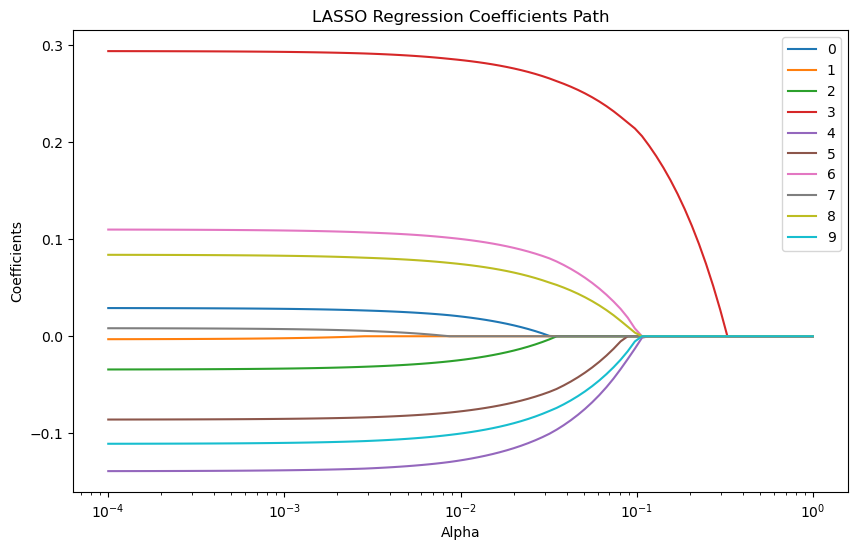

In [2]:
import numpy as np
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

# 生成样本数据
np.random.seed(0)
n_samples, n_features = 100, 10
X = np.random.randn(n_samples, n_features)
y = np.random.randn(n_samples)

# 初始化α值的范围
alphas = np.logspace(-4, 0, 100)

# 存储模型的系数
coefs = []

# 创建Lasso对象，并进行系数估计
for alpha in alphas:
    model = Lasso(alpha=alpha)
    model.fit(X, y)
    coefs.append(model.coef_)

# 绘制α值与系数路径的图表
plt.figure(figsize=(10, 6))
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('LASSO Regression Coefficients Path')
plt.axis('tight')
plt.legend(range(n_features))
plt.show()

可以看到，Lasso回归最终会趋于一条直线，原因就在于好多θ值已经均为0。LASSO回归使用L1范数作为惩罚项，具有稀疏性，即可以将某些系数压缩到零。这使得LASSO回归在**特征选择和变量筛选**方面非常有用。


## 岭回归


岭回归（Ridge Regression）是一种用于解决线性回归问题的正则化方法。岭回归通过引入一个正则化项，即岭惩罚项，来解决这个问题。岭回归的目标函数由两部分组成：一个是最小化拟合残差的平方和，另一个是控制参数向量的大小的惩罚项。

具体地，岭回归的目标函数可表示为：

$$\underset{w}{min,} || Xw - y||_2^2 + \alpha ||w||_2^2$$

其中，$X$ 是输入数据矩阵，$y$ 是对应的观测值向量，$w$ 是待估计的参数向量，$\alpha$ 是一个控制正则化强度的超参数。

通过引入 $\alpha$ 的值，岭回归可以对参数向量进行限制，使其不会过大，从而减小过拟合的风险。较大的 $\alpha$ 值会增加正则化的程度，从而更加平衡模型的复杂度和拟合残差之间的权衡。